# 1300개의 데이터로 Transfer_Learning 하기

- VGG19 모델에 1300개의 데이터를 넣고 학습을 시켜보자
- Augmentation을 하였을 때와 하지 않았을 때의 성능의 차이를 살펴보자

## Step 1. 실험환경 set-up

#### 라이브러리 실행

In [1]:
# 모델 관련 라이브러리
from tensorflow.keras.models import load_model
from tensorflow.keras             import utils, regularizers
from tensorflow.keras.models      import Sequential, load_model
from tensorflow.keras.layers      import Conv2D, MaxPooling2D, AveragePooling2D, Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers  import Adam
from tensorflow.keras.constraints import MaxNorm

import os                       # I/O 관련된 작업에 필요한 패키지 
import numpy             as np  # 데이터 array 작업에 필요한 패키지
import tensorflow        as tf  # 딥러닝 관련된 작업에 필요한 패키지
import matplotlib.pyplot as plt # 데이터 시각화에 관련된 작업에 필요한 패키지

#### GPU 사용 여부보기

In [2]:
gpus = tf.config.experimental.list_logical_devices('GPU')

if len(gpus) > 1:
    strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
    print(f'Running on multiple GPUs {[gpu.name for gpu in gpus]}')
elif len(gpus) == 1:
    strategy = tf.distribute.get_strategy()
    print(f'Running on single GPU {gpus[0].name}')
else:
    strategy = tf.distribute.get_strategy()
    print('Running on CPU')

print(f'Number of accelerators: {strategy.num_replicas_in_sync}')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Running on multiple GPUs ['/device:GPU:0', '/device:GPU:1']
Number of accelerators: 2


#### 필요한 변수들 생성

In [3]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# BATCH_SIZE 변수
BATCH_SIZE = 32

# 이미지 사이즈 변수
IMAGE_SIZE = [256, 256]

# EPOCH 크기 변수
EPOCHS = 150

#### GPU 사용여부 확인

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

## Step 2. 데이터 준비하기

먼저 아래의 링크에서 데이터를 다운 받을 것

https://drive.google.com/drive/folders/1Pi5qyX080zY2IdGT1TvvLraBO9DHBxJl?usp=sharing

받은 후 터미널 창에 아래의 명령어들을 차례로 입력

```
$ cd ~/Downloads && cp CellPin ~/aiffel
```

#### 데이터의 개수 확인

In [5]:
# 데이터 ROOT 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'cellpin/CellPin_0601/CellPin')
print(ROOT_PATH)

train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/train/*/*'))
test_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/test/*/*'))
val_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/val/*/*'))

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

/home/mochafreddo/cellpin/CellPin_0601/CellPin
780
260
260


#### train 데이터 안에 정상 이미지 수와 CPE 이미지 수

In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if 'normal' in filename])
print('NORMAL images count in Train set :' + str(COUNT_NORMAL))

COUNT_CPE = len([filename for filename in train_filenames if 'cpe' in filename])
print('CPE images count in Train set :' + str(COUNT_CPE))

NORMAL images count in Train set :429
CPE images count in Train set :351


#### val 데이터 안에 정상 이미지 수와 CPE 이미지 수

In [7]:
COUNT_NORMAL = len([filename for filename in val_filenames if 'normal' in filename])
print('NORMAL images count in Validation set :' + str(COUNT_NORMAL))

COUNT_CPE = len([filename for filename in val_filenames if 'cpe' in filename])
print('CPE images count in Validation set :' + str(COUNT_CPE))

NORMAL images count in Validation set :143
CPE images count in Validation set :117


#### test 데이터 안에 정상 이미지 수와 CPE 이미지 수

In [8]:
COUNT_NORMAL = len([filename for filename in test_filenames if 'normal' in filename])
print('NORMAL images count in Test set :' + str(COUNT_NORMAL))

COUNT_CPE = len([filename for filename in test_filenames if 'cpe' in filename])
print('CPE images count in Test set :' + str(COUNT_CPE))

NORMAL images count in Test set :143
CPE images count in Test set :117


#### tf.data 인스턴스를 만들기

In [9]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [10]:
train_list_ds

<TensorSliceDataset shapes: (), types: tf.string>

In [11]:
len(train_list_ds)

780

#### train data와 val data의 개수 확인

In [12]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print('Train images count :' + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print('Validation images count :' + str(VAL_IMG_COUNT))

Train images count :780
Validation images count :260


#### 라벨 이름들 확인

In [13]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/train/*"))])
print(CLASS_NAMES)

['normal' 'cpe']


#### 라벨링 함수를 만들어 보기

In [14]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == 'cpe'

In [15]:
train_list_ds.map(get_label, num_parallel_calls=AUTOTUNE)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


<ParallelMapDataset shapes: (), types: tf.bool>

In [16]:
train_list_ds

<TensorSliceDataset shapes: (), types: tf.string>

#### decode_img 함수와 process_path 함수를 만들기

In [17]:
def decode_img(img):
  # 이미지를 uint8 tensor로 바꾼다.
  img = tf.image.decode_jpeg(img, channels = 3)
  # img를 범위 [0,1]의 float32 데이터 타입으로 바꾼다.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정한다.
  return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

#### train과 val에 함수들 적용해주기

In [18]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

#### 전처리 함수 만들기 및 적용

In [19]:
def augment(image,label):
    image = tf.image.flip_left_right(image)  # 좌우 반전
    image = tf.image.flip_up_down(image)  # 상하 반전
    return image,label

def prepare_for_training(ds, shuffle_buffer_size = 1000, with_aug = False):
    
    if  with_aug:
        ds = ds.map(
            augment,  # augment 함수 적용
            num_parallel_calls = 2
            )    

    ds = ds.shuffle(buffer_size = shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size = AUTOTUNE)

    return ds

In [20]:
train_ds_no_aug = prepare_for_training(train_ds, with_aug = False)
val_ds_no_aug = prepare_for_training(val_ds, with_aug = False)


train_ds_aug = prepare_for_training(train_ds, with_aug = True)
val_ds_aug = prepare_for_training(val_ds, with_aug = True)

#### Image shape를 변경 체크하기

In [21]:
for image, label in train_ds_no_aug.take(1):
    print('Image shape :', image.numpy().shape)
    print('Label :', label.numpy().shape)

Image shape : (32, 256, 256, 3)
Label : (32,)


In [22]:
# for image, label in train_ds_aug.take(1):
#     print('Image shape :', image.numpy().shape)
#     print('Label :', label.numpy().shape)

#### test 데이터 셋도 만들어 보기 & 데이터의 갯수 확인

In [23]:
test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + '/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls = AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

260


## Step 3. 데이터 시각화

#### 16개의 샘플 꺼내서 확인

In [24]:
# image_batch, label_batch = next(iter(train_ds_no_aug))

# def show_batch(image_batch, label_batch):
#     plt.figure(figsize = (10, 10))
#     for n in range(16):
#         ax = plt.subplot(4, 4, n + 1)
#         plt.imshow(image_batch[n], cmap = 'gray')
#         if label_batch[n]:
#             plt.title('CPE')
#         else:
#             plt.title('NORMAL')
#         plt.axis('off')

# show_batch(image_batch.numpy(), label_batch.numpy())

In [25]:
image_batch, label_batch = next(iter(train_ds_aug))

label_batch

<tf.Tensor: shape=(32,), dtype=bool, numpy=
array([ True, False,  True, False, False,  True,  True,  True, False,
        True,  True,  True, False,  True,  True, False,  True, False,
       False,  True, False,  True, False,  True,  True,  True,  True,
       False, False, False,  True, False])>

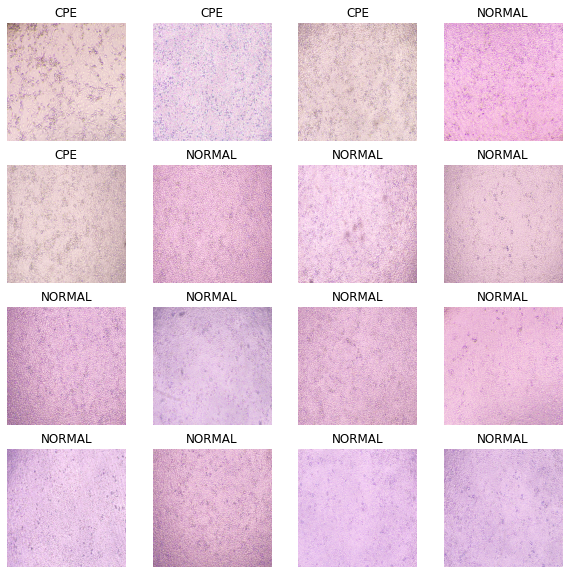

In [26]:
image_batch, label_batch = next(iter(train_ds_aug))

def show_batch(image_batch, label_batch):
    plt.figure(figsize = (10, 10))
    for n in range(16):
        ax = plt.subplot(4, 4, n + 1)
        plt.imshow(image_batch[n], cmap = 'gray')
        if label_batch[n]:
            plt.title('CPE')
        else:
            plt.title('NORMAL')
        plt.axis('off')

show_batch(image_batch.numpy(), label_batch.numpy())

In [27]:
with strategy.scope():
    vgg_layer = tf.keras.applications.VGG19(include_top = False,
                                            weights = "imagenet",
                                            input_shape = (256, 256, 3),
                                            classes = 1,
                                            classifier_activation = "sigmoid")

    fc_layer = [
        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(4096),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Dense(4096),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Dense(1),
        tf.keras.layers.Activation('sigmoid')
    ]

In [28]:
with strategy.scope():
    vgg_layer.trainable

In [29]:
with strategy.scope():
    vgg_layer.trainable = False
    vgg_layer.trainable

In [30]:
with strategy.scope():
    no_aug_model = tf.keras.models.Sequential([vgg_layer] + fc_layer)

In [31]:
no_aug_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 8, 8, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              134221824 
_________________________________________________________________
activation (Activation)      (None, 4096)              0         
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
activation_1 (Activation)    (None, 4096)              0

In [32]:
with strategy.scope():
    with_aug_model = tf.keras.models.Sequential([vgg_layer] + fc_layer)

In [33]:
with_aug_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 8, 8, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              134221824 
_________________________________________________________________
activation (Activation)      (None, 4096)              0         
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
activation_1 (Activation)    (None, 4096)             

## Step 5. 모델 훈련

#### GPU사용하여 model complie

In [34]:
with strategy.scope():

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name = 'precision'),
        tf.keras.metrics.Recall(name = 'recall')
    ]
    
    no_aug_model.compile(
        optimizer = 'adam',
        loss = 'binary_crossentropy',
        metrics = METRICS
    )
     
    no_aug_check_point = tf.keras.callbacks.ModelCheckpoint(ROOT_PATH +'/0602_data1300_model4/VGG19_FC_no_aug.h5')

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [35]:
with strategy.scope():
    
    with_aug_model.compile(
        optimizer = 'adam',
        loss = 'binary_crossentropy',
        metrics = METRICS
    )
    

    with_aug_check_point = tf.keras.callbacks.ModelCheckpoint(ROOT_PATH +'/0602_data1300_model4/VGG19_FC_with_aug.h5')

#### 모델 fitting

In [36]:
history_no_aug_model = no_aug_model.fit(
    train_ds_no_aug,
    steps_per_epoch = TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = val_ds_no_aug,
    validation_steps = VAL_IMG_COUNT // BATCH_SIZE,
    callbacks = [no_aug_check_point]
)

Epoch 1/150
INFO:tensorflow:batch_all_reduce: 6 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 6 all-reduces with algorithm = nccl, num_packs = 1
24/24 [==============================] - 44s 1000ms/step - loss: 13.5653 - accuracy: 0.5257 - precision: 0.4731 - recall: 0.4935 - val_loss: 0.4720 - val_accuracy: 0.8008 - val_precision: 0.7051 - val_recall: 0.9565
Epoch 2/150
24/24 [==============================] - 22s 954ms/step - loss: 0.4105 - accuracy: 0.8306 - precision: 0.8144 - recall: 0.7965 - val_loss: 0.2988 - val_accuracy: 0.8633 - val_precision: 0.8175 - val_recall: 0.8957
Epoch 3/150
24/24 [==============================] - 24s 1s/step - loss: 0.3452 - accuracy: 0.8539 - precision: 0.8603 - recall: 0.8338 - val_loss: 0.2706 - val_accuracy: 0.8906 - val_precision: 0.9490 - val_recall: 0.8017
Epoch 4/150
24/24 [==============================] - 21s 896ms/step - loss: 0.2694 - accuracy: 0.8993 - precision: 0.9232 - recall: 0.8490 - val_loss: 0.

24/24 [==============================] - 21s 897ms/step - loss: 0.2131 - accuracy: 0.9353 - precision: 0.9779 - recall: 0.8760 - val_loss: 0.2068 - val_accuracy: 0.9258 - val_precision: 0.9450 - val_recall: 0.8879
Epoch 73/150
24/24 [==============================] - 22s 948ms/step - loss: 0.2318 - accuracy: 0.9231 - precision: 0.9723 - recall: 0.8388 - val_loss: 0.1531 - val_accuracy: 0.9609 - val_precision: 0.9569 - val_recall: 0.9569
Epoch 74/150
24/24 [==============================] - 21s 919ms/step - loss: 0.2447 - accuracy: 0.9127 - precision: 0.9810 - recall: 0.8348 - val_loss: 0.1644 - val_accuracy: 0.9531 - val_precision: 0.9200 - val_recall: 0.9829
Epoch 75/150
24/24 [==============================] - 21s 920ms/step - loss: 0.2568 - accuracy: 0.9095 - precision: 0.9701 - recall: 0.8306 - val_loss: 0.1618 - val_accuracy: 0.9609 - val_precision: 0.9344 - val_recall: 0.9828
Epoch 76/150
24/24 [==============================] - 22s 945ms/step - loss: 0.2463 - accuracy: 0.9086 - 

Epoch 144/150
24/24 [==============================] - 22s 942ms/step - loss: 0.1862 - accuracy: 0.9468 - precision: 1.0000 - recall: 0.8711 - val_loss: 0.2867 - val_accuracy: 0.9375 - val_precision: 0.8769 - val_recall: 1.0000
Epoch 145/150
24/24 [==============================] - 21s 926ms/step - loss: 0.1869 - accuracy: 0.9400 - precision: 0.9787 - recall: 0.8874 - val_loss: 0.1655 - val_accuracy: 0.9727 - val_precision: 0.9658 - val_recall: 0.9741
Epoch 146/150
24/24 [==============================] - 22s 935ms/step - loss: 0.2043 - accuracy: 0.9360 - precision: 0.9869 - recall: 0.8712 - val_loss: 0.1575 - val_accuracy: 0.9570 - val_precision: 0.9906 - val_recall: 0.9130
Epoch 147/150
24/24 [==============================] - 22s 947ms/step - loss: 0.3928 - accuracy: 0.8481 - precision: 0.9972 - recall: 0.6954 - val_loss: 0.2716 - val_accuracy: 0.9297 - val_precision: 0.8760 - val_recall: 0.9826
Epoch 148/150
24/24 [==============================] - 22s 942ms/step - loss: 0.2801 - a

In [37]:
history_with_aug_model = with_aug_model.fit(
    train_ds_aug,
    steps_per_epoch = TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = val_ds_aug,
    validation_steps = VAL_IMG_COUNT // BATCH_SIZE,
    callbacks = [with_aug_check_point]
)

Epoch 1/150
INFO:tensorflow:batch_all_reduce: 6 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 6 all-reduces with algorithm = nccl, num_packs = 1
24/24 [==============================] - 42s 1s/step - loss: 0.5102 - accuracy: 0.7632 - precision: 0.9253 - recall: 0.7233 - val_loss: 0.2351 - val_accuracy: 0.9492 - val_precision: 0.9474 - val_recall: 0.9391
Epoch 2/150
24/24 [==============================] - 23s 984ms/step - loss: 0.3574 - accuracy: 0.8637 - precision: 0.9588 - recall: 0.7233 - val_loss: 0.1952 - val_accuracy: 0.9570 - val_precision: 0.9558 - val_recall: 0.9474
Epoch 3/150
24/24 [==============================] - 23s 982ms/step - loss: 0.4428 - accuracy: 0.7950 - precision: 0.9213 - recall: 0.6391 - val_loss: 0.1860 - val_accuracy: 0.9492 - val_precision: 0.9558 - val_recall: 0.9310
Epoch 4/150
24/24 [==============================] - 23s 1s/step - loss: 0.2784 - accuracy: 0.9096 - precision: 0.9676 - recall: 0.8373 - val_loss: 0.1991 

24/24 [==============================] - 21s 912ms/step - loss: 0.2176 - accuracy: 0.9262 - precision: 0.9583 - recall: 0.8829 - val_loss: 0.1344 - val_accuracy: 0.9570 - val_precision: 0.9339 - val_recall: 0.9741
Epoch 73/150
24/24 [==============================] - 21s 914ms/step - loss: 0.2358 - accuracy: 0.9186 - precision: 0.9607 - recall: 0.8474 - val_loss: 0.1465 - val_accuracy: 0.9609 - val_precision: 0.9565 - val_recall: 0.9565
Epoch 74/150
24/24 [==============================] - 21s 914ms/step - loss: 0.2445 - accuracy: 0.9102 - precision: 0.9472 - recall: 0.8403 - val_loss: 0.1484 - val_accuracy: 0.9570 - val_precision: 0.9492 - val_recall: 0.9573
Epoch 75/150
24/24 [==============================] - 21s 904ms/step - loss: 0.2436 - accuracy: 0.9172 - precision: 0.9836 - recall: 0.8313 - val_loss: 0.1492 - val_accuracy: 0.9570 - val_precision: 0.9565 - val_recall: 0.9483
Epoch 76/150
24/24 [==============================] - 22s 929ms/step - loss: 0.1925 - accuracy: 0.9441 - 

24/24 [==============================] - 22s 937ms/step - loss: 0.2098 - accuracy: 0.9364 - precision: 1.0000 - recall: 0.8533 - val_loss: 0.1598 - val_accuracy: 0.9609 - val_precision: 0.9649 - val_recall: 0.9483
Epoch 150/150
24/24 [==============================] - 22s 956ms/step - loss: 0.2748 - accuracy: 0.9046 - precision: 0.9906 - recall: 0.8119 - val_loss: 0.1795 - val_accuracy: 0.9492 - val_precision: 0.9397 - val_recall: 0.9478


## Step 6. 결과 확인 및 시각화

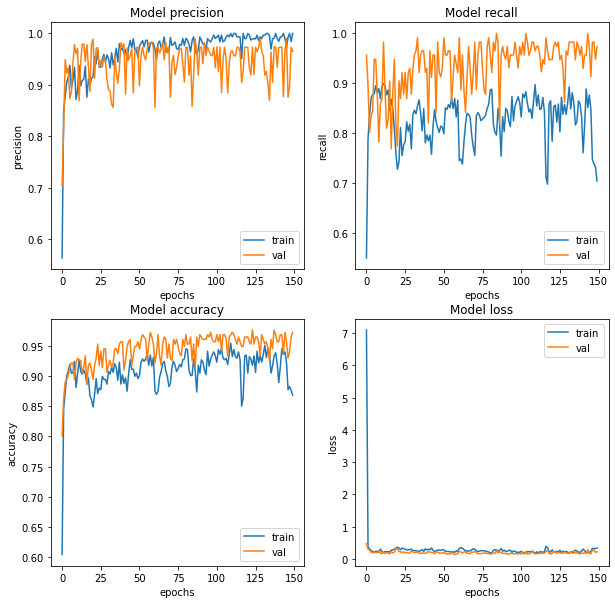

In [38]:
fig, ax = plt.subplots(2, 2, figsize = (10, 10))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_no_aug_model.history[met])
    ax[i].plot(history_no_aug_model.history['val_' + met])
    ax[i].set_title(f'Model {met}')
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

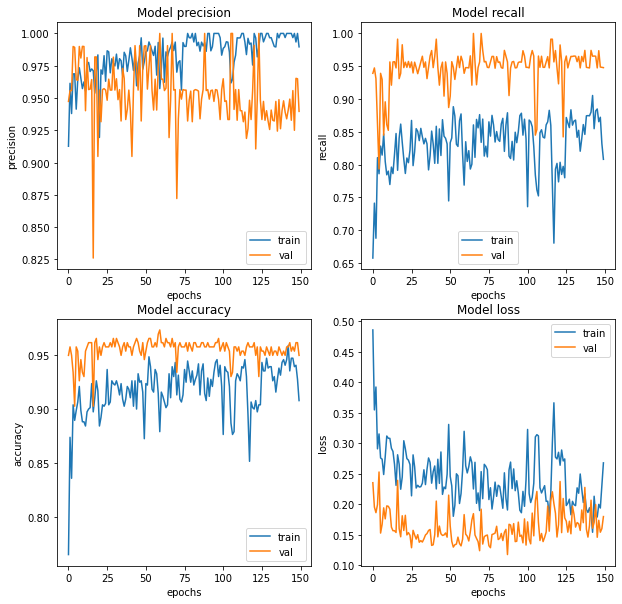

In [39]:
fig, ax = plt.subplots(2, 2, figsize = (10, 10))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_with_aug_model.history[met])
    ax[i].plot(history_with_aug_model.history['val_' + met])
    ax[i].set_title(f'Model {met}')
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

## Step 7. Test dataset 검정해보기

In [24]:
with strategy.scope():
    no_aug_model = tf.keras.models.load_model(ROOT_PATH +'/0602_data1300_model4/VGG19_FC_no_aug.h5')

loss, acc, prec, rec = no_aug_model.evaluate(test_ds)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [25]:
with strategy.scope():
    with_aug_model = tf.keras.models.load_model(ROOT_PATH +'/0602_data1300_model4/VGG19_FC_with_aug.h5')
    
loss, acc, prec, rec = with_aug_model.evaluate(test_ds)

9/9 [==============================] - 5s 185ms/step - loss: 0.2545 - accuracy: 0.9308 - precision: 0.9304 - recall: 0.9145


## Step 8. Freeze 풀고 다시 학습하기

#### augmentation 안한 모델 Freeze 풀어주기

In [26]:
with strategy.scope():
    no_aug_model.layers[0].trainable = True
    no_aug_model.layers[0].trainable

In [27]:
no_aug_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 8, 8, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              134221824 
_________________________________________________________________
activation (Activation)      (None, 4096)              0         
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
activation_1 (Activation)    (None, 4096)              0

#### augmentation 한 모델 Freeze 풀어주기

In [28]:
with strategy.scope():
    with_aug_model.layers[0].trainable = True
    with_aug_model.layers[0].trainable

In [29]:
with_aug_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 8, 8, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              134221824 
_________________________________________________________________
activation (Activation)      (None, 4096)              0         
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
activation_1 (Activation)    (None, 4096)             

#### GPU를 사용하여 모델을 장착

In [31]:
with strategy.scope():
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name = 'precision'),
        tf.keras.metrics.Recall(name = 'recall')
    ]
    
    no_aug_model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5),
        loss = 'binary_crossentropy',
        metrics = METRICS
    )
     
    no_aug_check_point = tf.keras.callbacks.ModelCheckpoint(ROOT_PATH +'/0602_data1300_model4/VGG19_no_aug.h5')

In [32]:
with strategy.scope():
    
    with_aug_model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5),
        loss = 'binary_crossentropy',
        metrics = METRICS
    )    

    with_aug_check_point = tf.keras.callbacks.ModelCheckpoint(ROOT_PATH +'/0602_data1300_model4/VGG19_with_aug.h5')

#### 모델 학습

In [33]:
history_no_aug_model = no_aug_model.fit(
    train_ds_no_aug,
    steps_per_epoch = TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = val_ds_no_aug,
    validation_steps = VAL_IMG_COUNT // BATCH_SIZE,
    callbacks = [no_aug_check_point]
)

Epoch 1/150
INFO:tensorflow:batch_all_reduce: 38 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 38 all-reduces with algorithm = nccl, num_packs = 1
24/24 [==============================] - 42s 1s/step - loss: 1.3874 - accuracy: 0.6668 - precision: 0.8105 - recall: 0.3678 - val_loss: 0.4788 - val_accuracy: 0.8047 - val_precision: 0.9452 - val_recall: 0.6000
Epoch 2/150
24/24 [==============================] - 23s 973ms/step - loss: 0.5963 - accuracy: 0.6973 - precision: 0.9207 - recall: 0.3045 - val_loss: 0.4208 - val_accuracy: 0.8242 - val_precision: 0.9600 - val_recall: 0.6316
Epoch 3/150
24/24 [==============================] - 23s 998ms/step - loss: 0.4116 - accuracy: 0.7734 - precision: 0.9823 - recall: 0.4707 - val_loss: 0.3480 - val_accuracy: 0.8555 - val_precision: 0.9875 - val_recall: 0.6870
Epoch 4/150
24/24 [==============================] - 22s 937ms/step - loss: 0.2854 - accuracy: 0.8952 - precision: 0.9417 - recall: 0.8337 - val_loss: 0.

24/24 [==============================] - 22s 931ms/step - loss: 0.0131 - accuracy: 0.9987 - precision: 0.9977 - recall: 0.9995 - val_loss: 0.0461 - val_accuracy: 0.9844 - val_precision: 0.9911 - val_recall: 0.9737
Epoch 37/150
24/24 [==============================] - 22s 925ms/step - loss: 0.0077 - accuracy: 0.9992 - precision: 1.0000 - recall: 0.9982 - val_loss: 0.0806 - val_accuracy: 0.9844 - val_precision: 0.9823 - val_recall: 0.9823
Epoch 38/150
24/24 [==============================] - 22s 928ms/step - loss: 0.0044 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0486 - val_accuracy: 0.9805 - val_precision: 0.9823 - val_recall: 0.9737
Epoch 39/150
24/24 [==============================] - 22s 934ms/step - loss: 0.0033 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0338 - val_accuracy: 0.9883 - val_precision: 1.0000 - val_recall: 0.9739
Epoch 40/150
24/24 [==============================] - 22s 957ms/step - loss: 0.0027 - accuracy: 1.0000 - 

Epoch 72/150
24/24 [==============================] - 22s 952ms/step - loss: 7.2502e-05 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1077 - val_accuracy: 0.9883 - val_precision: 0.9912 - val_recall: 0.9825
Epoch 73/150
24/24 [==============================] - 21s 915ms/step - loss: 8.1692e-05 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1099 - val_accuracy: 0.9883 - val_precision: 0.9912 - val_recall: 0.9826
Epoch 74/150
24/24 [==============================] - 22s 950ms/step - loss: 7.6674e-05 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1112 - val_accuracy: 0.9883 - val_precision: 0.9912 - val_recall: 0.9825
Epoch 75/150
24/24 [==============================] - 22s 965ms/step - loss: 1.4243e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0992 - val_accuracy: 0.9883 - val_precision: 0.9912 - val_recall: 0.9825
Epoch 76/150
24/24 [==============================] - 21s 918ms/step - loss:

Epoch 108/150
24/24 [==============================] - 22s 935ms/step - loss: 1.1741e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0635 - val_accuracy: 0.9766 - val_precision: 0.9908 - val_recall: 0.9558
Epoch 109/150
24/24 [==============================] - 21s 916ms/step - loss: 1.4515e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0676 - val_accuracy: 0.9766 - val_precision: 0.9909 - val_recall: 0.9561
Epoch 110/150
24/24 [==============================] - 22s 930ms/step - loss: 2.2589e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0980 - val_accuracy: 0.9727 - val_precision: 0.9911 - val_recall: 0.9487
Epoch 111/150
24/24 [==============================] - 21s 912ms/step - loss: 8.4805e-05 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0968 - val_accuracy: 0.9727 - val_precision: 0.9909 - val_recall: 0.9478
Epoch 112/150
24/24 [==============================] - 21s 898ms/step - 

24/24 [==============================] - 22s 943ms/step - loss: 6.3375e-06 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1539 - val_accuracy: 0.9727 - val_precision: 0.9908 - val_recall: 0.9474
Epoch 144/150
24/24 [==============================] - 21s 897ms/step - loss: 2.7480e-05 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1493 - val_accuracy: 0.9766 - val_precision: 0.9911 - val_recall: 0.9569
Epoch 145/150
24/24 [==============================] - 22s 923ms/step - loss: 2.3336e-05 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1071 - val_accuracy: 0.9844 - val_precision: 0.9912 - val_recall: 0.9739
Epoch 146/150
24/24 [==============================] - 22s 937ms/step - loss: 8.6433e-06 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1543 - val_accuracy: 0.9766 - val_precision: 0.9910 - val_recall: 0.9565
Epoch 147/150
24/24 [==============================] - 22s 928ms/step - loss: 1.7879e-

In [34]:
history_with_aug_model = with_aug_model.fit(
    train_ds_aug,
    steps_per_epoch = TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = val_ds_aug,
    validation_steps = VAL_IMG_COUNT // BATCH_SIZE,
    callbacks = [with_aug_check_point]
)

Epoch 1/150
INFO:tensorflow:batch_all_reduce: 38 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 38 all-reduces with algorithm = nccl, num_packs = 1
24/24 [==============================] - 39s 1s/step - loss: 4.6997 - accuracy: 0.6634 - precision: 0.8907 - recall: 0.6067 - val_loss: 0.5913 - val_accuracy: 0.8320 - val_precision: 0.9375 - val_recall: 0.6637
Epoch 2/150
24/24 [==============================] - 24s 1s/step - loss: 0.6594 - accuracy: 0.7159 - precision: 0.9243 - recall: 0.3598 - val_loss: 0.6125 - val_accuracy: 0.7031 - val_precision: 1.0000 - val_recall: 0.3448
Epoch 3/150
24/24 [==============================] - 25s 1s/step - loss: 0.6616 - accuracy: 0.6523 - precision: 1.0000 - recall: 0.2396 - val_loss: 0.5094 - val_accuracy: 0.7812 - val_precision: 0.9538 - val_recall: 0.5391
Epoch 4/150
24/24 [==============================] - 24s 1s/step - loss: 0.6421 - accuracy: 0.7748 - precision: 0.9435 - recall: 0.4653 - val_loss: 0.4778 - va

Epoch 37/150
24/24 [==============================] - 24s 1s/step - loss: 0.0068 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0655 - val_accuracy: 0.9805 - val_precision: 0.9912 - val_recall: 0.9658
Epoch 38/150
24/24 [==============================] - 24s 1s/step - loss: 0.0059 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0875 - val_accuracy: 0.9609 - val_precision: 0.9907 - val_recall: 0.9224
Epoch 39/150
24/24 [==============================] - 23s 998ms/step - loss: 0.0033 - accuracy: 0.9985 - precision: 1.0000 - recall: 0.9965 - val_loss: 0.0995 - val_accuracy: 0.9648 - val_precision: 0.9909 - val_recall: 0.9316
Epoch 40/150
24/24 [==============================] - 24s 1s/step - loss: 0.0032 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0810 - val_accuracy: 0.9805 - val_precision: 0.9911 - val_recall: 0.9652
Epoch 41/150
24/24 [==============================] - 23s 981ms/step - loss: 0.0012 - accuracy: 1.000

24/24 [==============================] - 22s 945ms/step - loss: 0.0312 - accuracy: 0.9883 - precision: 0.9915 - recall: 0.9829 - val_loss: 0.0921 - val_accuracy: 0.9805 - val_precision: 0.9583 - val_recall: 1.0000
Epoch 74/150
24/24 [==============================] - 22s 936ms/step - loss: 0.0477 - accuracy: 0.9830 - precision: 0.9808 - recall: 0.9796 - val_loss: 0.0857 - val_accuracy: 0.9844 - val_precision: 0.9911 - val_recall: 0.9737
Epoch 75/150
24/24 [==============================] - 22s 943ms/step - loss: 0.0234 - accuracy: 0.9917 - precision: 0.9852 - recall: 0.9960 - val_loss: 0.0685 - val_accuracy: 0.9805 - val_precision: 0.9910 - val_recall: 0.9649
Epoch 76/150
24/24 [==============================] - 23s 975ms/step - loss: 0.0258 - accuracy: 0.9903 - precision: 0.9967 - recall: 0.9795 - val_loss: 0.0888 - val_accuracy: 0.9805 - val_precision: 0.9664 - val_recall: 0.9914
Epoch 77/150
24/24 [==============================] - 23s 981ms/step - loss: 0.0159 - accuracy: 0.9926 - 

Epoch 109/150
24/24 [==============================] - 22s 950ms/step - loss: 1.5082e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1165 - val_accuracy: 0.9844 - val_precision: 0.9912 - val_recall: 0.9741
Epoch 110/150
24/24 [==============================] - 23s 968ms/step - loss: 1.1692e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1212 - val_accuracy: 0.9844 - val_precision: 0.9912 - val_recall: 0.9739
Epoch 111/150
24/24 [==============================] - 22s 960ms/step - loss: 1.5855e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1236 - val_accuracy: 0.9844 - val_precision: 0.9912 - val_recall: 0.9739
Epoch 112/150
24/24 [==============================] - 22s 950ms/step - loss: 1.2232e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1298 - val_accuracy: 0.9844 - val_precision: 0.9912 - val_recall: 0.9741
Epoch 113/150
24/24 [==============================] - 21s 909ms/step - 

24/24 [==============================] - 23s 985ms/step - loss: 5.7659e-05 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1191 - val_accuracy: 0.9844 - val_precision: 0.9912 - val_recall: 0.9739
Epoch 145/150
24/24 [==============================] - 22s 955ms/step - loss: 4.6185e-05 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1193 - val_accuracy: 0.9844 - val_precision: 0.9912 - val_recall: 0.9741
Epoch 146/150
24/24 [==============================] - 23s 968ms/step - loss: 4.4710e-05 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1176 - val_accuracy: 0.9844 - val_precision: 0.9912 - val_recall: 0.9739
Epoch 147/150
24/24 [==============================] - 22s 956ms/step - loss: 3.6550e-05 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1205 - val_accuracy: 0.9844 - val_precision: 0.9911 - val_recall: 0.9737
Epoch 148/150
24/24 [==============================] - 22s 958ms/step - loss: 1.6835e-

#### 시각화

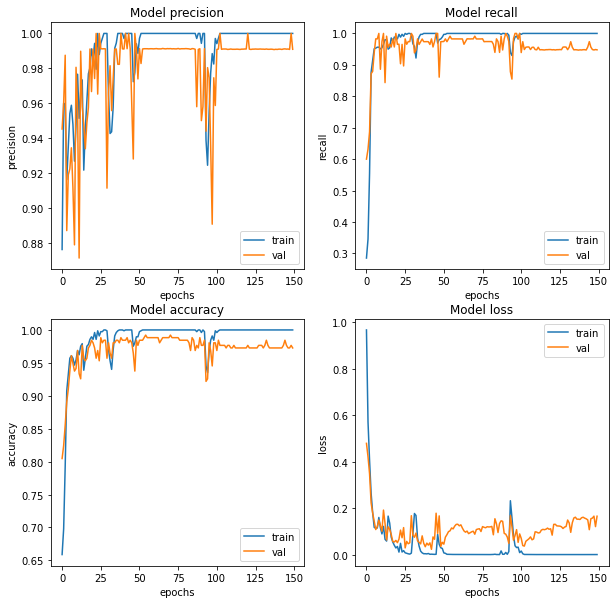

In [35]:
fig, ax = plt.subplots(2, 2, figsize = (10, 10))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_no_aug_model.history[met])
    ax[i].plot(history_no_aug_model.history['val_' + met])
    ax[i].set_title(f'Model {met}')
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

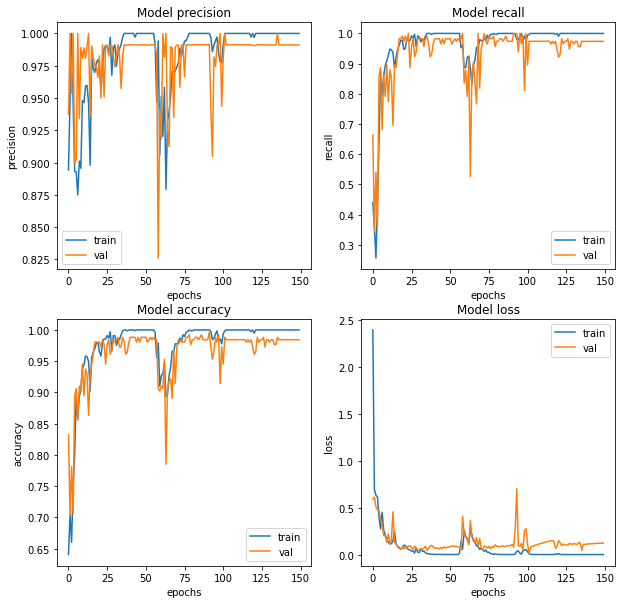

In [36]:
fig, ax = plt.subplots(2, 2, figsize = (10, 10))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_with_aug_model.history[met])
    ax[i].plot(history_with_aug_model.history['val_' + met])
    ax[i].set_title(f'Model {met}')
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

#### 최종 결과 확인

In [37]:
no_aug_model = tf.keras.models.load_model(ROOT_PATH +'/0602_data1300_model4/VGG19_no_aug.h5')
loss, acc, prec, rec = no_aug_model.evaluate(test_ds)

9/9 [==============================] - 4s 207ms/step - loss: 0.2922 - accuracy: 0.9731 - precision: 0.9911 - recall: 0.9487


In [38]:
with_aug_model = tf.keras.models.load_model(ROOT_PATH +'/0602_data1300_model4/VGG19_with_aug.h5')   
loss, acc, prec, rec = with_aug_model.evaluate(test_ds)

9/9 [==============================] - 3s 219ms/step - loss: 0.1821 - accuracy: 0.9692 - precision: 1.0000 - recall: 0.9316


## Discussion